In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
from torch import nn
from torch.optim import Adam

from transformers import BertTokenizer, BertModel, BertForSequenceClassification

from tqdm import tqdm

/home/user/ishfaqm0/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
sarcasm_df = pd.read_csv("data/train-balanced-sarcasm.csv")


## Data Exploration

In [4]:
sarcasm_df.head()


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
sarcasm_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


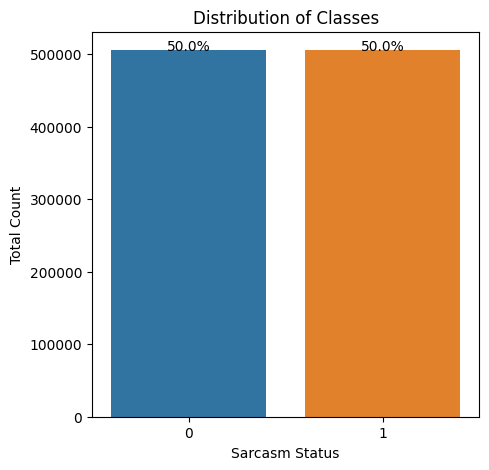

In [6]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x="label", data=sarcasm_df)
ax.set(title="Distribution of Classes", xlabel="Sarcasm Status", ylabel="Total Count")
total = float(len(sarcasm_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:1.1f}%".format((height / total) * 100),
        ha="center",
    )
plt.show()


In [7]:
sarcasm_df["subreddit"].value_counts()[:5]


AskReddit          65677
politics           39496
worldnews          26377
leagueoflegends    21037
pcmasterrace       18988
Name: subreddit, dtype: int64

In [5]:
top_reddits = ["AskReddit", "politics", "worldnews", "leagueoflegends", "pcmasterrace"]

subreddit_df = pd.DataFrame()
subreddit_df["subreddit"] = top_reddits
subreddit_df["sarcastic"] = np.nan
subreddit_df["natural"] = np.nan
subreddit_df["total"] = np.nan

# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits
for i in range(len(top_reddits)):
    temp = sarcasm_df.loc[
        sarcasm_df["subreddit"] == subreddit_df.subreddit.iloc[i]
    ].copy()
    length = len(temp)
    count_sarcastic = len(temp.loc[temp["label"] == 1])
    subreddit_df.loc[i, "sarcastic"] = count_sarcastic
    subreddit_df.loc[i, "natural"] = length - count_sarcastic
    subreddit_df.loc[i, "total"] = length


In [9]:
subreddit_df


,subreddit,sarcastic,natural,total
0,AskReddit,26367.0,39310.0,65677.0
1,politics,23910.0,15586.0,39496.0
2,worldnews,16948.0,9429.0,26377.0
3,leagueoflegends,11409.0,9628.0,21037.0
4,pcmasterrace,10760.0,8228.0,18988.0


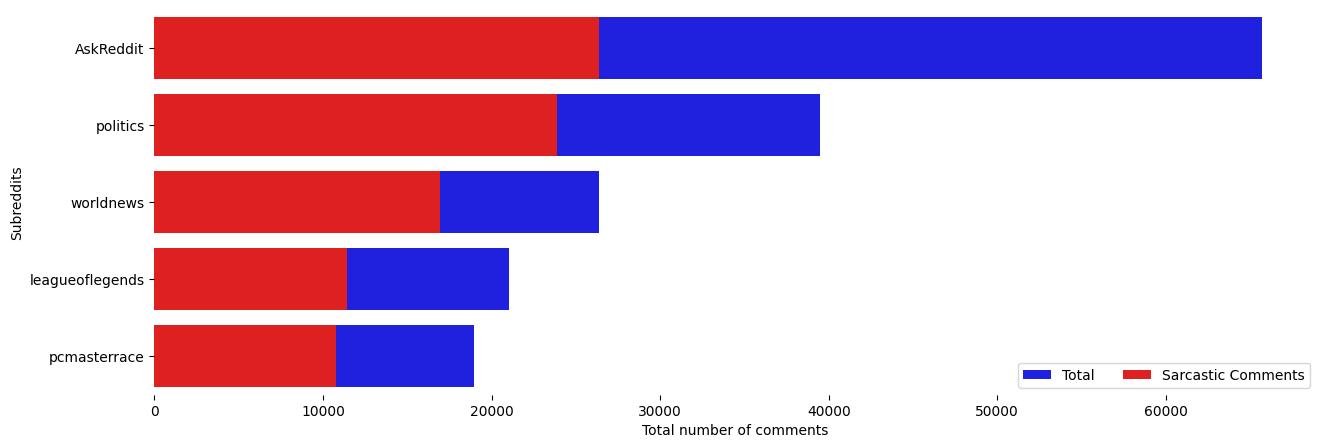

In [10]:
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit_df, label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(
    x="sarcastic",
    y="subreddit",
    data=subreddit_df,
    label="Sarcastic Comments",
    color="r",
)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Subreddits", xlabel="Total number of comments")
sns.despine(left=True, bottom=True)


## Preprocessing

In [4]:
# We just need comment & label columns
# So, let's remove others.
sarcasm_df.drop(
    [
        "author",
        "subreddit",
        "score",
        "ups",
        "downs",
        "date",
        "created_utc",
        "parent_comment",
    ],
    axis=1,
    inplace=True,
)
# remove empty rows
sarcasm_df.dropna(inplace=True)
sarcasm_df.head()


,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [5]:
# Here we inspect data for missing values
sarcasm_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   label    1010773 non-null  int64 
 1   comment  1010773 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


In [6]:
# Some comments are missing, so we drop the corresponding rows.
sarcasm_df.dropna(subset=["comment"], inplace=True)
# also convert to lower case and remove punctuation
sarcasm_df["comment"] = sarcasm_df["comment"].str.lower()
sarcasm_df["comment"] = sarcasm_df["comment"].str.replace("[^\w\s]", "")


/tmp/ipykernel_3310131/1034982800.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  sarcasm_df["comment"] = sarcasm_df["comment"].str.replace("[^\w\s]", "")


In [7]:
# Now we compare the number of instances for each class (1 - sarcasm, 0 - not sarcasm). We can see, that the dataset is balanced and classes have almost the same size
sarcasm_df["label"].value_counts()


0    505405
1    505368
Name: label, dtype: int64

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    sarcasm_df["comment"], sarcasm_df["label"], test_size=0.3, random_state=42
)


## Feature Encoding and Model Training

In [10]:
# create tf-idf encoder
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# encode training data
train_features = tf_idf.fit_transform(x_train)
# encode test data
test_features = tf_idf.transform(x_test)

# logistic regression model with tf-idf encoder
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(train_features, y_train)
pred_labels_log_reg = log_reg.predict(test_features)
print("Logistic regression accuracy: ", accuracy_score(y_test, pred_labels_log_reg))


Logistic regression accuracy:  0.7195513666103841


In [36]:
# load the GloVe embeddings from a text file
def load_glove_embeddings(file):
    embeddings = {}
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

# function that returns the mean of the word embeddings for a sentence
def glove_mean(sentence, embeddings, dim=100):
    words = sentence.split()
    vectors = np.zeros((len(words), dim))
    for i, word in enumerate(words):
        if word in embeddings:
            vectors[i] = embeddings[word]
    # check if vectors is empty or contains nan values
    if np.isnan(vectors).any() or len(vectors) == 0:
        # replace with zeros or random numbers
        return np.zeros(dim)
        # return np.random.rand(dim)
    else:
        return np.mean(vectors, axis=0)


# load the GloVe embeddings
glove_file = "glove.6B.100d.txt"
glove_embeddings = load_glove_embeddings(glove_file)

In [ ]:
# encode the training and test data using GloVe mean-pooling and convert them to PyTorch tensors
X_train_glove = torch.tensor(
    [glove_mean(sent, glove_embeddings) for sent in x_train], dtype=torch.float32
)
X_test_glove = torch.tensor(
    [glove_mean(sent, glove_embeddings) for sent in x_test], dtype=torch.float32
)

# convert Y_train and Y_test to PyTorch tensors
Y_train_glove = torch.tensor(y_train.values, dtype=torch.long)
Y_test_glove = torch.tensor(y_test.values, dtype=torch.long)

In [9]:
# convert the labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [10]:
# load pre-trained BERT model and 
model_name = "bert-base-uncased"
bert_model = BertForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [8]:
# load BERTtokenizer for sequence classification
bert_tokenizer = BertTokenizer.from_pretrained(model_name)

# encode training data using BERT tokenizer
train_encodings = bert_tokenizer(x_train.tolist(), truncation=True, padding=True)
# convert to PyTorch tensors
X_train_bert = torch.tensor(train_encodings["input_ids"])
train_attention_mask = torch.tensor(train_encodings["attention_mask"])

# encode test data using BERT tokenizer
test_encodings = bert_tokenizer(x_test.tolist(), truncation=True, padding=True)
# convert to PyTorch tensors
X_test_bert = torch.tensor(test_encodings["input_ids"])
test_attention_mask = torch.tensor(test_encodings["attention_mask"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [9]:
# save the encoded data to disk for later use (because encoding takes time)
# torch.save(X_train_bert, "X_train_bert.pt")
# torch.save(train_attention_mask, "train_attention_mask.pt")
# torch.save(X_test_bert, "X_test_bert.pt")
# torch.save(test_attention_mask, "test_attention_mask.pt")


In [11]:
# load the encoded data from disk
X_train_bert = torch.load("X_train_bert.pt")
train_attention_mask = torch.load("train_attention_mask.pt")
X_test_bert = torch.load("X_test_bert.pt")
test_attention_mask = torch.load("test_attention_mask.pt")

In [12]:
# create data loaders
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(X_train_bert, train_attention_mask, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=200, shuffle=True)

test_data = TensorDataset(X_test_bert, test_attention_mask, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [13]:
# wrap the BERT model with nn.DataParallel and pass a list of GPU ids
bert_model = nn.DataParallel(bert_model, device_ids=[0, 1, 2, 3, 4])

# move the BERT model to the GPU
bert_model.to(device)

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [13]:
# define a cross entropy loss function
criterion = nn.CrossEntropyLoss()
# define an optimizer
optimizer = Adam(bert_model.parameters(), lr=0.01)

epochs = 1

for epoch in range(epochs):
    optimizer.zero_grad()
    # loop over the batches in the train loader
    for input_ids, attention_mask, labels in tqdm(train_loader):
        # move the batch to the GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        # pass the encoded inputs and attention masks to BERT model and get the output logits
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits # shape: (batch_size, num_labels)
        # compute the loss
        loss = criterion(logits, labels)
        # update the parameters
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, loss: {loss.item():.4f}")
    
# save the trained model to disk
torch.save(bert_model.state_dict(), "bert_model.pt")

100%|██████████| 3538/3538 [1:15:01<00:00,  1.27s/it]


Epoch 1, loss: 268.6432


In [14]:
# load the trained model from disk
bert_model.load_state_dict(torch.load("bert_model.pt"))

<All keys matched successfully>

In [15]:
# forward pass through the model on the test data
pred_labels_bert = []
for input_ids, attention_mask, labels in tqdm(test_loader):
    # move the batch to the GPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    # pass the encoded inputs and attention masks to BERT model and get the output logits
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits # shape: (batch_size, num_labels)
    # get the predicted labels by taking the argmax of the logits and append them to a list
    pred_labels_bert.extend(torch.argmax(logits, dim=1).cpu().numpy())
print("BERT accuracy:", accuracy_score(y_test_tensor, pred_labels_bert))


100%|██████████| 4738/4738 [17:39<00:00,  4.47it/s]

BERT accuracy: 0.49924480265934995


In [38]:
# the MLP model with one hidden layer of size 100, batch normalization, and ReLU activation
class MLP(nn.Module):
    def __init__(self, input_size=100, hidden_size=100, output_size=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.5)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout2 = nn.Dropout(0.5)
        self.act2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.act2(x)
        return x

mlp = MLP()

In [39]:
# Move the model and data to the GPU
mlp.to(device)
X_train_glove = X_train_glove.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_glove = X_test_glove.to(device)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(mlp.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp(X_train_glove)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, loss: {loss.item():.4f}")

# forward pass through the model on the test data
outputs = mlp(X_test_glove)
# get the predicted labels by taking the argmax of the outputs
pred_labels_mlp = torch.argmax(outputs, dim=1).cpu().numpy()
print("Multilayer perceptron accuracy:", accuracy_score(y_test_tensor, pred_labels_mlp))

Epoch 1, loss: 0.6583
Epoch 2, loss: 0.6588
Epoch 3, loss: 0.6586
Epoch 4, loss: 0.6585
Epoch 5, loss: 0.6581
Epoch 6, loss: 0.6583
Epoch 7, loss: 0.6582
Epoch 8, loss: 0.6580
Epoch 9, loss: 0.6579
Epoch 10, loss: 0.6579
Epoch 11, loss: 0.6580
Epoch 12, loss: 0.6580
Epoch 13, loss: 0.6579
Epoch 14, loss: 0.6578
Epoch 15, loss: 0.6576
Epoch 16, loss: 0.6578
Epoch 17, loss: 0.6575
Epoch 18, loss: 0.6575
Epoch 19, loss: 0.6572
Epoch 20, loss: 0.6577
Epoch 21, loss: 0.6575
Epoch 22, loss: 0.6573
Epoch 23, loss: 0.6575
Epoch 24, loss: 0.6574
Epoch 25, loss: 0.6573
Epoch 26, loss: 0.6571
Epoch 27, loss: 0.6571
Epoch 28, loss: 0.6573
Epoch 29, loss: 0.6569
Epoch 30, loss: 0.6570
Epoch 31, loss: 0.6570
Epoch 32, loss: 0.6569
Epoch 33, loss: 0.6567
Epoch 34, loss: 0.6568
Epoch 35, loss: 0.6567
Epoch 36, loss: 0.6571
Epoch 37, loss: 0.6566
Epoch 38, loss: 0.6565
Epoch 39, loss: 0.6563
Epoch 40, loss: 0.6566
Epoch 41, loss: 0.6567
Epoch 42, loss: 0.6565
Epoch 43, loss: 0.6564
Epoch 44, loss: 0.65

## Model Evaluation

In [42]:
# generate the classification report
report = classification_report(y_test_tensor, pred_labels_mlp)
print("Classification report:")
print(report)

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.73      0.65    151387
           1       0.64      0.46      0.54    151845

    accuracy                           0.60    303232
   macro avg       0.61      0.60      0.59    303232
weighted avg       0.61      0.60      0.59    303232



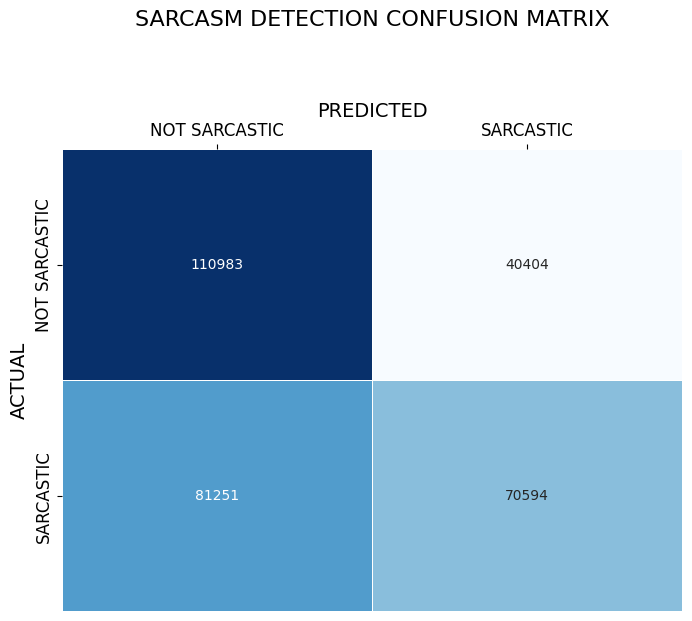

In [43]:
# plot Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test_tensor, pred_labels_mlp), index=['NOT SARCASTIC','SARCASTIC'], columns=['NOT SARCASTIC', 'SARCASTIC'])

fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, cbar=False, cmap='Blues', linewidths=0.5,fmt='.0f')
ax.set_title('SARCASM DETECTION CONFUSION MATRIX', fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL', fontsize=14)
ax.set_xlabel('PREDICTED', fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)